### Under what parameter combinations does Atkin rdark become negative?

In [11]:
from scipy.stats import qmc
import numpy as np

import csv
import xarray as xr
import pandas as pd
import os
import netCDF4 as nc4
import sys
import shutil
from tempfile import TemporaryFile                                                                                                                                 
import argparse                                                                                                                                                                                                                                                                                                       
import tempfile 
import random
import re

import scipy.optimize as opt

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from matplotlib.colors import BoundaryNorm


#### Constants - these are a mix of pft parameters and hard coded values 
-  Values here are reasonable estimates of PFT values

In [12]:
vcmax25tops  = [57.5, 34.1, 33.15, 33.55, 28.7, 31.9, 71.3, 62.1, 37.8, 42.9, 31.2, 78]
nitr_stoichs  = [0.033, 0.029, 0.04, 0.033, 0.04, 0.04, 0.033, 0.04, 0.04, 0.04, 0.04, 0.04]
slatops = [0.0144, 0.006, 0.0288, 0.0108, 0.036, 0.036, 0.0144, 0.036, 0.036, 0.036, 0.036, 0.03]
lnc_tops =  [a / b for a,  b  in  zip(nitr_stoichs,  slatops)]
umolC_to_kgC = 12.0e-9
g_per_kg = 1000.0
tfrz = 273.15
veg_tempk = 298.15 # Current veg temp
r0s = [1.756, 1.4995, 1.4995, 1.756, 1.756, 1.756, 2.0749, 2.0749, 2.0749, 2.1956, 2.1956, 2.1956]
r1 = 0.2061  # Hard coded
r2 = -0.0402 # Hard coded
tgrowth = 298.15 # Lagged vegetation temperature over acclimation timescale
TrefC = 25.0 # Hard coded

lai = np.linspace(0,8,9)

#### For a range of temperature, vcmax, nitrogen stoichiometry, slatop and R0 - which part of parameter  space leads to negative lmr
-  Because r2  is negative,  if lagged temperature is high then r_t_refs_atkin can become negative 
- This is  more likely to occur if r0 is low or lnc_top is low

In [13]:
tgrowths = np.linspace(263.15, 308.15, 5)  ## 0 to 35
vcmax25tops  = np.linspace(30,100, 3)
nitr_stoichs = np.linspace(0.02, 0.05, 3)
slatops = np.linspace(0.006, 0.04, 3)
r0s  = np.linspace(1.0,2, 10)

for a in range(0,len(vcmax25tops)) : 
    for b in range(0,len(nitr_stoichs)) :
        for c in range(0,len(slatops)) :
            for d in range(0,len(r0s)) : 
                for e in range(0,len(tgrowths)) :
                    
                    veg_tempk = tgrowths[e] # lagged temperature the same as current temperature
                    
                    kn = np.exp(0.00963 * vcmax25tops[a] - 2.43)
                    nscaler = np.exp(-kn * lai)
                    
                    lnc_top = nitr_stoichs[b] / slatops[c]
                     
                    # Atkin
                    r_t_refs_atkin = nscaler * ( r0s[d] + r1 * lnc_top + r2 * max(0, (tgrowths[e] - tfrz)) )
                    lmr = r_t_refs_atkin * np.exp(0.1012 * (veg_tempk - tfrz - TrefC) + -0.0005 * ((veg_tempk - tfrz)**2 - TrefC**2))
                    
                    if any(lmr < 0.0) :
                        
                        print('negative')
                        print('vcmax', vcmax25tops[a], ', nitr stoich', nitr_stoichs[b], ', slatop', slatops[c], ', r0', r0s[d], ', tgrowth', tgrowths[e] - 273.15)


negative
vcmax 30.0 , nitr stoich 0.02 , slatop 0.023 , r0 1.0 , tgrowth 35.0
negative
vcmax 30.0 , nitr stoich 0.02 , slatop 0.023 , r0 1.1111111111111112 , tgrowth 35.0
negative
vcmax 30.0 , nitr stoich 0.02 , slatop 0.023 , r0 1.2222222222222223 , tgrowth 35.0
negative
vcmax 30.0 , nitr stoich 0.02 , slatop 0.04 , r0 1.0 , tgrowth 35.0
negative
vcmax 30.0 , nitr stoich 0.02 , slatop 0.04 , r0 1.1111111111111112 , tgrowth 35.0
negative
vcmax 30.0 , nitr stoich 0.02 , slatop 0.04 , r0 1.2222222222222223 , tgrowth 35.0
negative
vcmax 30.0 , nitr stoich 0.035 , slatop 0.023 , r0 1.0 , tgrowth 35.0
negative
vcmax 30.0 , nitr stoich 0.035 , slatop 0.04 , r0 1.0 , tgrowth 35.0
negative
vcmax 30.0 , nitr stoich 0.035 , slatop 0.04 , r0 1.1111111111111112 , tgrowth 35.0
negative
vcmax 30.0 , nitr stoich 0.035 , slatop 0.04 , r0 1.2222222222222223 , tgrowth 35.0
negative
vcmax 30.0 , nitr stoich 0.05 , slatop 0.04 , r0 1.0 , tgrowth 35.0
negative
vcmax 30.0 , nitr stoich 0.05 , slatop 0.04 , 

## By PFT - high temperature and low r0 
- here we set parameters to be reasonable but make  r0 * 0.7 it's normal value, and then plot lmr v lai for a temperature of 35 degrees

In [14]:
vcmax25tops  = [57.5, 34.1, 33.15, 33.55, 28.7, 31.9, 71.3, 62.1, 37.8, 42.9, 31.2, 78]
nitr_stoichs  = [0.033, 0.029, 0.04, 0.033, 0.04, 0.04, 0.033, 0.04, 0.04, 0.04, 0.04, 0.04]
slatops = [0.0144, 0.006, 0.0288, 0.0108, 0.036, 0.036, 0.0144, 0.036, 0.036, 0.036, 0.036, 0.03]
lnc_tops =  [a / b for a,  b  in  zip(nitr_stoichs,  slatops)]
umolC_to_kgC = 12.0e-9
g_per_kg = 1000.0
tfrz = 273.15
veg_tempk =  308.15 #298.15
r0s_def = [1.756, 1.4995, 1.4995, 1.756, 1.756, 1.756, 2.0749, 2.0749, 2.0749, 2.1956, 2.1956, 2.1956]
r0s = [x  * 0.7  for x in  r0s_def]
print(r0s)
#r0s = r0s_def
r1 = 0.2061
r2 = -0.0402
tgrowth = 308.15 #298.15
veg_tempk =  tgrowth
lai = np.linspace(0,8,9)

[1.2291999999999998, 1.04965, 1.04965, 1.2291999999999998, 1.2291999999999998, 1.2291999999999998, 1.4524299999999999, 1.4524299999999999, 1.4524299999999999, 1.53692, 1.53692, 1.53692]


In [15]:
lmr = []

for i in range(0,len(slatops)):
   
    kn = np.exp(0.00963 * vcmax25tops[i]  - 2.43)
    nscaler = np.exp(-kn * lai)
    
    # Atkin
    r_t_refs_atkin = ( nscaler *  (r0s[i] + r1 * lnc_tops[i] + r2 * max(0, (tgrowth - tfrz)) ) )

    lmr.append( r_t_refs_atkin * np.exp(0.1012 * (veg_tempk - tfrz - TrefC) + -0.0005 * ((veg_tempk - tfrz)**2 - TrefC**2)) )
                    

In [16]:
pftnames = ['broadleaf_evergreen_tropical_tree','needleleaf_evergreen_extratrop_tree',
         'needleleaf_colddecid_extratrop_tree','broadleaf_evergreen_extratrop_tree',
        'broadleaf_hydrodecid_tropical_tree','broadleaf_colddecid_extratrop_tree',
        'broadleaf_evergreen_extratrop_shrub','broadleaf_hydrodecid_extratrop_shrub',
        'broadleaf_colddecid_extratrop_shrub', 'arctic_c3_grass',
        'cool_c3_grasss','c4_grass']

''

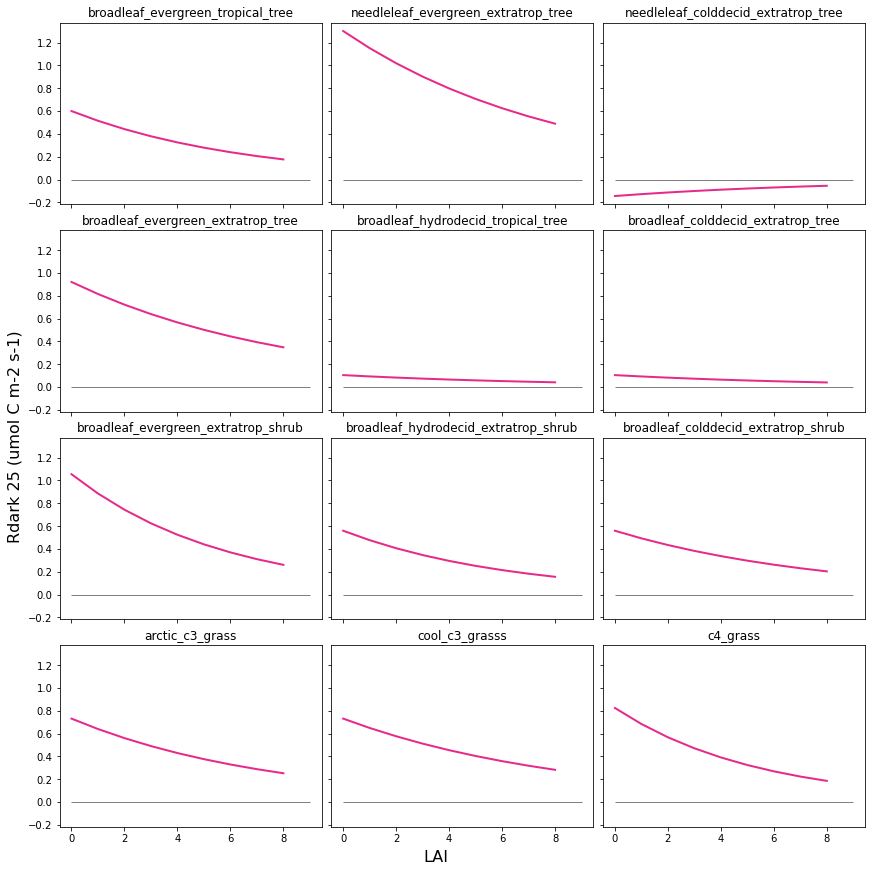

In [17]:
dark = cm.get_cmap('Dark2', 8)
colormap = dark(range(8))


fig2, axs = plt.subplots(nrows=4, ncols=3, figsize=(12,12), sharex=True, sharey=True, constrained_layout=True)
    
axs = axs.flatten()    
   
for i in range(0,len(slatops)):   
    
    axs[i].plot(lai, lmr[i],  label = 'Atkin', color=colormap[3], linewidth=2)
    axs[i].hlines(y=0, xmin=0, xmax=9, linewidth=1, color='grey')
    axs[i].set_title(pftnames[i])
    
fig2.supxlabel(r'LAI', fontsize=16)
fig2.supylabel(r'Rdark 25 (umol C m-2 s-1)', fontsize=16)
;

### Repeat with 0.5 * default  value  of r0

In [18]:
r0s_def = [1.756, 1.4995, 1.4995, 1.756, 1.756, 1.756, 2.0749, 2.0749, 2.0749, 2.1956, 2.1956, 2.1956]
r0s = [x  * 0.5  for x in  r0s_def]
print(r0s)

[0.878, 0.74975, 0.74975, 0.878, 0.878, 0.878, 1.03745, 1.03745, 1.03745, 1.0978, 1.0978, 1.0978]


In [19]:
lmr = []

for i in range(0,len(slatops)):
   
    kn = np.exp(0.00963 * vcmax25tops[i]  - 2.43)
    nscaler = np.exp(-kn * lai)
    
    # Atkin
    r_t_refs_atkin = ( nscaler *  (r0s[i] + r1 * lnc_tops[i] + r2 * max(0, (tgrowth - tfrz)) ) )

    lmr.append( r_t_refs_atkin * np.exp(0.1012 * (veg_tempk - tfrz - TrefC) + -0.0005 * ((veg_tempk - tfrz)**2 - TrefC**2)) )
        

''

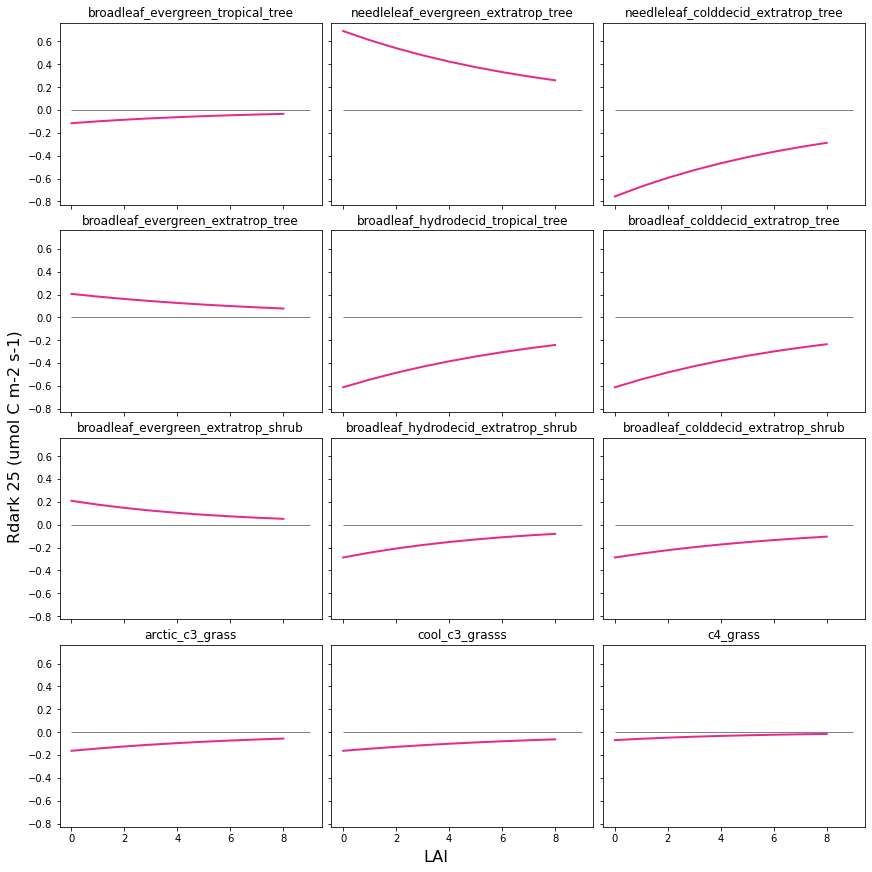

In [20]:
fig2, axs = plt.subplots(nrows=4, ncols=3, figsize=(12,12), sharex=True, sharey=True, constrained_layout=True)
    
axs = axs.flatten()    
   
for i in range(0,len(slatops)):   
    
    axs[i].plot(lai, lmr[i],  label = 'Atkin', color=colormap[3], linewidth=2)
    axs[i].hlines(y=0, xmin=0, xmax=9, linewidth=1, color='grey')
    axs[i].set_title(pftnames[i])
    
fig2.supxlabel(r'LAI', fontsize=16)
fig2.supylabel(r'Rdark 25 (umol C m-2 s-1)', fontsize=16)
;